## Dataset preparation

In [1]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# ===== Load data; replace with your paths =====
results_path = 'D:/ET-AL/Results/Jarvis_1000iters/'
data_downselect = pd.read_pickle('D:/ET-AL/Jarvis_cfid/data_cleaned.pkl')
descriptors_all = pd.read_pickle('D:/ET-AL/Jarvis_features.pkl').drop(columns=['Compound'])
descriptors = descriptors_all.drop(columns=descriptors_all.columns[np.where(descriptors_all.var() == 0)])

In [2]:
data_l = pd.read_pickle(results_path + 'data_l.pkl')  # Labeled dataset
data_test = pd.read_pickle(results_path + 'data_test.pkl')  # Test set
data_u = data_downselect.drop(index=data_l.index.union(data_test.index), inplace=False)  # Unlabeled dataset

sample_path = np.load(results_path + 'sample_path.npy').astype(int)
samples = sample_path[sample_path != 0]
samples_etal = data_downselect.loc[samples]  # Samples selected by ET-AL
samples_rand = data_u.sample(n=samples.shape[0], random_state=42)  # Randomly selected samples

data_l_etal = pd.concat([data_l, samples_etal]) # Two training sets
data_l_rand = pd.concat([data_l, samples_rand])

In [3]:
# Featurize training and test sets
x_etal= descriptors.loc[data_l_etal.index]
x_rand = descriptors.loc[data_l_rand.index]
x_test = descriptors.loc[data_test.index]

# Responses: bulk and shear moduli
B_etal = data_downselect.loc[data_l_etal.index]['bulk_modulus_kv']
B_rand = data_downselect.loc[data_l_rand.index]['bulk_modulus_kv']
B_test = data_downselect.loc[data_test.index]['bulk_modulus_kv']

G_etal = data_downselect.loc[data_l_etal.index]['shear_modulus_gv']
G_rand = data_downselect.loc[data_l_rand.index]['shear_modulus_gv']
G_test = data_downselect.loc[data_test.index]['shear_modulus_gv']

## SVM
A support vector machine (SVM)-based ML pipeline.

The material feature vector $x$ is first standardized, then reduced dimension by principal component analysis (PCA). The first 7 principal components are taken as the representation and input to an SVM model.

In [170]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

n_rep = 10
def train_svr_etal_B(i):
    svr_etal_B = make_pipeline(StandardScaler(), PCA(n_components=7), SVR(C=10, kernel='rbf'))
    svr_etal_B.fit(x_etal, B_etal)
    return svr_etal_B.score(x_test, B_test)

def train_svr_rand_B(i):
    svr_rand_B = make_pipeline(StandardScaler(), PCA(n_components=7), SVR(C=10, kernel='rbf'))
    svr_rand_B.fit(x_rand, B_rand)
    return svr_rand_B.score(x_test, B_test)

svr_r2_etal_B = Parallel(n_jobs=10)(delayed(train_svr_etal_B)(i) for i in range (n_rep))
svr_r2_rand_B = Parallel(n_jobs=10)(delayed(train_svr_rand_B)(i) for i in range (n_rep))
print(np.mean(svr_r2_etal_B) - np.mean(svr_r2_rand_B))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=7)), ('svr', SVR(C=10))])

Grid cross-validation (CV) search for hyperparameter tuning.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
svr = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('svr', SVR())])
parameters = {'svr__kernel':('rbf', 'poly', 'sigmoid'), 'svr__C': [1,5,10], 'pca__n_components': [3,5,7,9]}
clf = GridSearchCV(svr, parameters)
clf.fit(x_etal, B_etal)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()), ('svr', SVR())]),
             param_grid={'pca__n_components': [3, 5, 7, 9],
                         'svr__C': [1, 5, 10],
                         'svr__kernel': ('rbf', 'poly', 'sigmoid')})

## AdaBoost
The adaptive boosting model under default settings.

In [4]:
from sklearn.ensemble import AdaBoostRegressor
n_rep = 30
ab_r2_etal_G = np.zeros(n_rep)
ab_r2_rand_G = np.zeros(n_rep)
for i in range(n_rep):
    ab_etal_G = AdaBoostRegressor(random_state=i).fit(x_etal, G_etal)
    ab_rand_G = AdaBoostRegressor(random_state=i).fit(x_rand, G_rand)
    ab_r2_rand_G[i] = ab_rand_G.score(x_test, G_test)
    ab_r2_etal_G[i] = ab_etal_G.score(x_test, G_test)

ab_r2_etal_B = np.zeros(n_rep)
ab_r2_rand_B = np.zeros(n_rep)
for i in range(n_rep):
    ab_etal_B = AdaBoostRegressor(random_state=i).fit(x_etal, B_etal)
    ab_rand_B = AdaBoostRegressor(random_state=i).fit(x_rand, B_rand)
    ab_r2_rand_B[i] = ab_rand_B.score(x_test, B_test)
    ab_r2_etal_B[i] = ab_etal_B.score(x_test, B_test)

## Random Forest
The random forest model under default settings.

In [79]:
from sklearn.ensemble import RandomForestRegressor
n_rep = 30
rf_r2_etal_G = np.zeros(n_rep)
rf_r2_rand_G = np.zeros(n_rep)
for i in range(n_rep):
    rf_etal_G = RandomForestRegressor(random_state=i).fit(x_etal, G_etal)
    rf_rand_G = RandomForestRegressor(random_state=i).fit(x_rand, G_rand)
    rf_r2_rand_G[i] = rf_rand_G.score(x_test, G_test)
    rf_r2_etal_G[i] = rf_etal_G.score(x_test, G_test)

In [80]:
rf_r2_etal_B = np.zeros(n_rep)
rf_r2_rand_B = np.zeros(n_rep)
for i in range(n_rep):
    rf_etal_B = RandomForestRegressor(random_state=i).fit(x_etal, B_etal)
    rf_rand_B = RandomForestRegressor(random_state=i).fit(x_rand, B_rand)
    rf_r2_rand_B[i] = rf_rand_B.score(x_test, B_test)
    rf_r2_etal_B[i] = rf_etal_B.score(x_test, B_test)

## Gradient Boost
The gradient boosting model under default settings.

In [44]:
from sklearn.ensemble import GradientBoostingRegressor
n_rep = 30
gb_r2_etal_G = np.zeros(n_rep)
gb_r2_rand_G = np.zeros(n_rep)
for i in range(n_rep):
    gb_etal_G = GradientBoostingRegressor(random_state=i).fit(x_etal, G_etal)
    gb_rand_G = GradientBoostingRegressor(random_state=i).fit(x_rand, G_rand)
    gb_r2_rand_G[i] = gb_rand_G.score(x_test, G_test)
    gb_r2_etal_G[i] = gb_etal_G.score(x_test, G_test)

In [45]:
gb_r2_etal_B = np.zeros(n_rep)
gb_r2_rand_B = np.zeros(n_rep)
for i in range(n_rep):
    gb_etal_B = GradientBoostingRegressor(random_state=i).fit(x_etal, B_etal)
    gb_rand_B = GradientBoostingRegressor(random_state=i).fit(x_rand, B_rand)
    gb_r2_rand_B[i] = gb_rand_B.score(x_test, B_test)
    gb_r2_etal_B[i] = gb_etal_B.score(x_test, B_test)

## Neural Net
A multi-layer perceptron (MLP) model with standardized materials features as input. Hyperparameters are tuned using Grid CV search.

In [43]:
from sklearn.neural_network import MLPRegressor
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
n_rep = 30
hidden_size = (128,)
batch_size = 32
max_iter = 500
alpha = 0.1
# learning_rate_init = 0.001
activation = 'relu'

def train_nn_etal_B(i):
    nn_etal_B = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=hidden_size, random_state=i, early_stopping=True, alpha=alpha, batch_size=batch_size,
    max_iter=max_iter, activation=activation))
    nn_etal_B.fit(x_etal, B_etal)
    return nn_etal_B.score(x_test, B_test)

def train_nn_rand_B(i):
    nn_rand_B = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=hidden_size, random_state=i, early_stopping=True, alpha=alpha, batch_size=batch_size,
    max_iter=max_iter, activation=activation))
    nn_rand_B.fit(x_rand, B_rand)
    return nn_rand_B.score(x_test, B_test)

nn_r2_etal_B = Parallel(n_jobs=10)(delayed(train_nn_etal_B)(i) for i in range (n_rep))
nn_r2_rand_B = Parallel(n_jobs=10)(delayed(train_nn_rand_B)(i) for i in range (n_rep))


def train_nn_etal_G(i):
    
    nn_etal_G = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=hidden_size, random_state=i, early_stopping=True, alpha=alpha, batch_size=batch_size,
    max_iter=max_iter, activation=activation))
    nn_etal_G.fit(x_etal, G_etal)
    return nn_etal_G.score(x_test, G_test)

def train_nn_rand_G(i):
    nn_rand_G = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=hidden_size, random_state=i, early_stopping=True, alpha=alpha, batch_size=batch_size,
    max_iter=max_iter, activation=activation))
    nn_rand_G.fit(x_rand, G_rand)
    return nn_rand_G.score(x_test, G_test)

nn_r2_etal_G = Parallel(n_jobs=10)(delayed(train_nn_etal_G)(i) for i in range (n_rep))
nn_r2_rand_G = Parallel(n_jobs=10)(delayed(train_nn_rand_G)(i) for i in range (n_rep))

(0.01653454377793251, 0.0028510784907186393)

Grid CV search for NN hyperparameter tuning.

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
nn = Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(early_stopping=True, max_iter=500, batch_size=32))])
parameters = {'mlp__alpha': [0.01, 0.05, 0.1],
              'mlp__activation': ('tanh', 'relu'),
              'mlp__hidden_layer_sizes': ((128,), (64,64), (128,128))
             }
clf = GridSearchCV(nn, parameters, verbose=3, n_jobs=-1)
clf.fit(x_etal, B_etal)
clf.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'mlp__activation': 'tanh',
 'mlp__alpha': 0.1,
 'mlp__hidden_layer_sizes': (128,)}

## Make plot

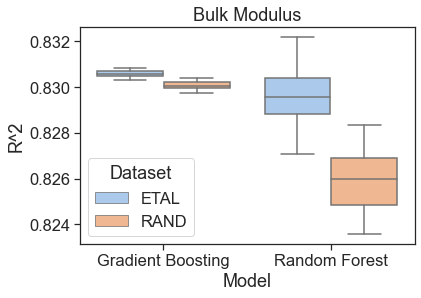

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
results = pd.read_pickle('D:/ET-AL/Results/ML/ML_r2_all.pkl')
sns.set_theme(style="ticks", palette='pastel', font_scale=1.5)
sns.boxplot(x='Model', y='R^2', hue='Dataset', data=results[(results['Target'] == 'B') & (results['Model'] != 'Neural Network')])
plt.title('Bulk Modulus')
plt.savefig('D:/ET-AL/plots/r2_B.svg', bbox_inches='tight')

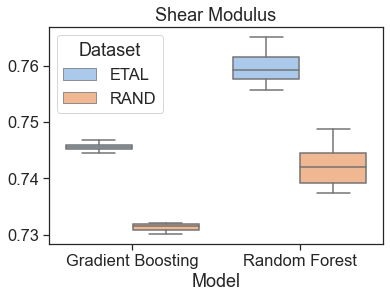

In [6]:
sns.set_theme(style="ticks", palette='pastel', font_scale=1.5)
sns.boxplot(x='Model', y='R^2', hue='Dataset', data=results[(results['Target'] == 'G') & (results['Model'] != 'Neural Network')])
plt.title('Shear Modulus')
plt.ylabel('')
plt.savefig('D:/ET-AL/plots/r2_G.svg', bbox_inches='tight')
# plt.savefig('D:/ET-AL/plots/r2_G.png', dpi=200, bbox_inches='tight')